In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from LeNet import LeNet
from tqdm import tqdm_notebook

from FGSM import FGSM
import numpy as np
import os

from sklearn import metrics

import matplotlib.pyplot as plt

# 读取MNIST数据集

In [4]:
trans = transforms.Compose([
    transforms.ToTensor(),
#     transforms.Normalize((0.1307,), (0.3081,))
])

train_set = torchvision.datasets.MNIST(root='/data/winddy/dataset/MNIST', train=True, download=True, transform=trans)
test_set = torchvision.datasets.MNIST(root='/data/winddy/dataset/MNIST', train=False, download=True, transform=trans)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=4, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=4, shuffle=True, num_workers=2)

In [5]:
device = torch.device("cuda:7" if torch.cuda.is_available() else "cpu")
print(device)

cuda:7


# 读取模型

In [7]:
model = LeNet()
model.load_state_dict(torch.load('./model/LeNet_MNIST_unNormalize.pt'))
model = model.to(device)

## 测试正常数据的准确率

In [12]:
# 准备模型
model.eval()
test_loss = 0
correct = 0

# 遍历数据集
target_arr = []
output_arr = []
with torch.no_grad():
    for data, target in tqdm_notebook(test_loader):    
        data, target = data.to(device), target.to(device)
        output = model(data)
        test_loss += torch.nn.functional.cross_entropy(output, target, reduction='sum').item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        target_arr.append(target.cpu().data.numpy())
        output_arr.append(output.cpu().data.numpy())
    test_loss /= len(test_loader.dataset)
    
print('test loss: {%0.4f}' % test_loss)
print('correct: {%0.4f}' % (correct/len(test_loader.dataset)) )


test loss: {0.2875}
correct: {0.9761}


# 生成攻击样本

In [13]:
epsilon = 0.3
criterion = nn.CrossEntropyLoss()
attacker = FGSM(model, criterion, epsilon)

fgsm = FGSM(model, criterion, epsilon)

# 生成MINST的对抗样本

In [14]:
# 准备模型
model.eval()
test_loss = 0
correct = 0

# 遍历数据集
target_arr = []
output_arr = []

for data, target in tqdm_notebook(test_loader):
    data, target = data.to(device), target.to(device)

    data, sign = fgsm(data, target)

    output = model(data)
    test_loss += torch.nn.functional.cross_entropy(output, target, reduction='sum').item()
    pred = output.argmax(dim=1, keepdim=True)
    correct += pred.eq(target.view_as(pred)).sum().item()

    target_arr.append(target.cpu().data.numpy())
    output_arr.append(output.cpu().data.numpy())
    
    
test_loss /= len(test_loader.dataset)
    
print('test loss: {%0.4f}' % test_loss)
print('correct: {%0.4f}' % (correct/len(test_loader.dataset)) )


test loss: {3.0216}
correct: {0.0543}


# 数据归一化跟没归一化的对比

In [114]:
trans = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

test_set = torchvision.datasets.MNIST(root='D:/dataset/MNIST', train=False, download=True, transform=trans)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=4, shuffle=True, num_workers=2)
dataiter = iter(test_loader)

In [22]:
# 可视化数据集
def imshow(img):
    img = img * 0.3081 + 0.1307
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.show()
def imshow_un(img):
#     img = img * 0.3081 + 0.1307
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


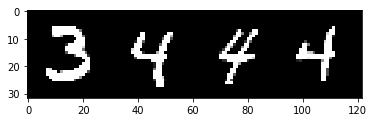

In [116]:
data_show, target_show = dataiter.next()
imshow_un(torchvision.utils.make_grid(data_show))

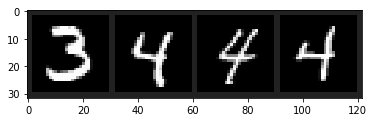

In [117]:
imshow(torchvision.utils.make_grid(data_show))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


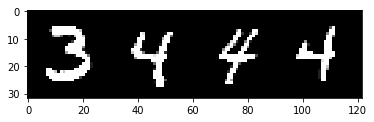

In [118]:
data_show = data_show.to(device)
data_pertubation, sign = fgsm(data_show, target)
data_pertubation = data_pertubation.cpu().data
imshow_un(torchvision.utils.make_grid(data_pertubation))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


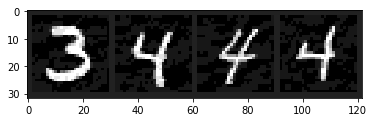

In [119]:
imshow(torchvision.utils.make_grid(data_pertubation))

In [111]:
trans = transforms.Compose([
    transforms.ToTensor(),
])

test_set = torchvision.datasets.MNIST(root='D:/dataset/MNIST', train=False, download=True, transform=trans)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=4, shuffle=True, num_workers=2)
dataiter = iter(test_loader)

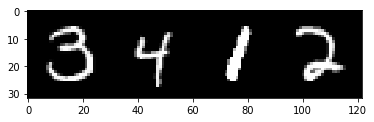

In [112]:
data_show, target_show = dataiter.next()
imshow_un(torchvision.utils.make_grid(data_show))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


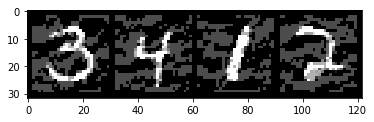

In [113]:
data_show = data_show.to(device)
data_pertubation, sign = fgsm(data_show, target)
data_pertubation = data_pertubation.cpu().data
imshow_un(torchvision.utils.make_grid(data_pertubation))

# 旋转测试

In [107]:
# 测试数据
trans = transforms.Compose([
    transforms.ToTensor(),
#     transforms.Normalize((0.1307,), (0.3081,))
])

test_set = torchvision.datasets.MNIST(root='D:/dataset/MNIST', train=False, download=True, transform=trans)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=True, num_workers=2)

In [108]:
iterater = iter(test_loader)

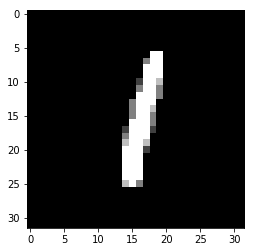

In [113]:
sample_X, sample_Y = iterater.next()
imshow_un(torchvision.utils.make_grid(sample_X))

In [114]:
x = sample_X[0][0]
size = 4
print(len(x)//size)
for i in range(len(x)//size):
    for j in range(len(x[0])//size):
        a = x[size*i:size*(i+1), size*j:size*(j+1)]
        a = np.rot90(a)
        a = np.ascontiguousarray(a)
        x[size*i:size*(i+1), size*j:size*(j+1)] = torch.tensor(a)
x = torch.unsqueeze(x,0)
x = torch.unsqueeze(x,0)
x.shape

7


torch.Size([1, 1, 28, 28])

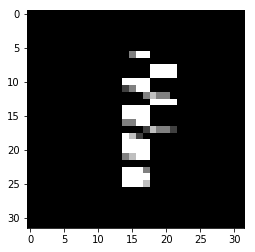

In [115]:
imshow_un(torchvision.utils.make_grid(x))

In [116]:
(model(x.to(device))).argmax()

tensor(5, device='cuda:0')

# 条件数

In [118]:
# 正常测试数据
trans = transforms.Compose([
    transforms.ToTensor(),
#     transforms.Normalize((0.1307,), (0.3081,))
])

test_set = torchvision.datasets.MNIST(root='D:/dataset/MNIST', train=False, download=True, transform=trans)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=True, num_workers=2)

In [ ]:
epsilon = 0.3
criterion = nn.CrossEntropyLoss()
attacker = FGSM(model, criterion, epsilon)
fgsm = FGSM(model, criterion, epsilon)

# 准备模型
model.eval()
test_loss = 0
correct = 0

# 遍历数据集
target_arr = []
output_arr = []

for data, target in tqdm_notebook(test_loader):
    data, target = data.to(device), target.to(device)

    data, sign = fgsm(data, target)

    output = model(data)
    test_loss += torch.nn.functional.cross_entropy(output, target, reduction='sum').item()
    pred = output.argmax(dim=1, keepdim=True)
    correct += pred.eq(target.view_as(pred)).sum().item()

    target_arr.append(target.cpu().data.numpy())
    output_arr.append(output.cpu().data.numpy())
    
    
test_loss /= len(test_loader.dataset)
    
print('test loss: {%0.4f}' % test_loss)
print('correct: {%0.4f}' % (correct/len(test_loader.dataset)) )